### This notebook pulls latest tweets on allergy, finds sentiment, most common words and plots tweeted user's location

In [1]:
import tweepy as tw
import pandas as pd
import geocoder
import json
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import itertools
import collections
import networkx as nx
from textblob import TextBlob #For Sentiment Analysis
import matplotlib.pyplot as plt #For Graphing the Data
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import re
import os

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)  # or 199

Get twitter consumer key, secret, access token and access token secret for your twitter account and perform authentication

In [ ]:
consumer_key = 'get key'
consumer_secret = 'get secret'
access_token = 'get token'
access_token_secret = 'get token secret'

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret) #Fill these in
auth.set_access_token(access_token, access_token_secret)  #Fill these in
api = tw.API(auth, wait_on_rate_limit=True)

Get frequently used words in English, they will be removed from tweets

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
search_word = 'allergy'
close_words =  [search_word, 'allergies', 'amp']
stop_words.update(close_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spunna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To get tweets within USA, use latitude and logitude of central USA and search within 1000 mile radius

In [5]:
usa_latitude = 40      # latitude of central USA
usa_longitude = -1000 # longitude of central USA
max_range = 1000      # search about 1000 miles to cover whole USA
t = tw.Cursor(api.search,
                    q='allergy -filter:retweets',
                    tweet_mode='extended',
                    geocode = "%f,%f,%dmi" % (usa_latitude, usa_longitude, max_range), 
                    lang="en").items(1)
for i in t:
    print(i)

In [6]:
# Utility function to clean tweet text by removing links, special characters using simple regex statements. 
def clean_tweet(tweet): 
        return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split()).lower()
    
# Utility function to classify sentiment of passed tweet using textblob's sentiment method 
def get_tweet_sentiment(tweet): 
    cleaned_tweet = clean_tweet(tweet)
    analysis = TextBlob(cleaned_tweet) 
    sentiment = 0
    if analysis.sentiment.polarity > 0: 
        sentiment = 1
    elif analysis.sentiment.polarity == 0: 
        sentiment = 0
    else: 
        sentiment = -1
    return cleaned_tweet, sentiment

# Utility function to get tweeted user's location co-ordinates
def get_location(location):
    cordinates = geocoder.arcgis(location)
    return cordinates.x, cordinates.y

# Function to get latest tweets, returns a dataframe with created time, text, sentiment, latitude and longitude
def get_tweets(query, count = 10): 
    # remove retweets
    new_search = query + " -filter:retweets"
    tweets_columns = ['created_at', 'location', 'sentiment', 'text', 'lat', 'long']
    tweets_df = pd.DataFrame(columns = tweets_columns)
    try: 
        maxid = None
        fetch = True
        prev_fetched = 0
        fetched_count = 0
        
        while (fetched_count < count and fetch):
            fetched_tweets = tw.Cursor(api.search,
                       q=new_search,
                       #geocode = "%f,%f,%dmi" % (usa_latitude, usa_longitude, max_range), 
                       tweet_mode='extended',
                       lang="en",
                        max_id= maxid).items(100)
          
            for tweet in fetched_tweets:
                text, sentiment = get_tweet_sentiment(tweet.full_text)
                long, lat = get_location(tweet.user.location)
                tweets_df = tweets_df.append({'created_at':tweet.created_at, 
                                  'location':tweet.user.location,
                                  'sentiment':sentiment,
                                  'text':text,
                                  'lat':lat,
                                  'long':long},
                                 ignore_index=True)
                maxid = tweet.id-1
                fetched_count = fetched_count + 1
               
            # if no new results, break the loop
            if (prev_fetched == fetched_count):
                fetch = False
                break;  
            prev_fetched = fetched_count
            print(fetched_count, tweets_df.shape)
        return fetched_count, tweets_df
    except tweepy.TweepError as e: 
        print("Error : " + str(e)) 

In [7]:
%%time
fetched_count, tweets = get_tweets(query = 'allergy', count = 200) 
if  ( fetched_count > 0):
    print('Total tweets fetched for allergy:', fetched_count)
    allergyTweets = tweets

100 (100, 6)
200 (200, 6)
Total tweets fetched for allergy: 200
Wall time: 1min 53s


Get latest 200 tweets and check first 5 records

In [8]:
allergyTweets.head()

,created_at,location,sentiment,text,lat,long
0,2019-03-30 22:44:06,Sacramento,1,enjoying sping until her bff allergy smacks me in the face,38.5794,-121.491
1,2019-03-30 22:43:44,Devon,-1,and elvis is in agony again 10 days now all day hes 90 percent then screaming pain docs say food allergy possibly or trapped wind 10 days though weve eliminated milk chocolate and any crap just doesnt seem right,50.753,-3.81163
2,2019-03-30 22:43:07,"Calgary, Alberta",-1,excuse me hives where how im out of allergy meds you fuck,51.0453,-114.063
3,2019-03-30 22:42:29,"Washington, DC",0,dont forget to take your allergy meds,38.8904,-77.032
4,2019-03-30 22:41:32,,1,getting my dog to take her allergy medicine is the most stressful thing ive ever had to do,None,None


Check sentiment of tweets, whether they are positive, negative or neutral. Visualize their percentage as a pie chart with following sentiment-color combination.

Positive-Green, Negative-Red, Neutral-Yellow

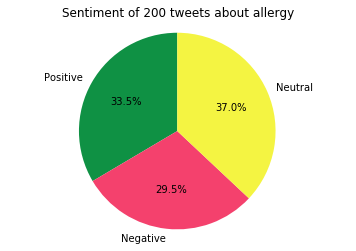

In [9]:
plt.show();
## declare the variables for the pie chart, using the Counter variables for “sizes”
sentiments = pd.Series(data=allergyTweets['sentiment'].value_counts(), index=[-1,0,1])
labels = 'Positive', 'Negative', 'Neutral'
sizes = [sentiments[1], sentiments[-1], sentiments[0]]
colors = ['#0f9144', '#f4416d', '#f4f442']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',shadow=False, startangle=90)
ax1.axis('equal')
plt.title('Sentiment of {} tweets about allergy'.format(fetched_count))
plt.show()

Common words found in Tweets (without stop words)

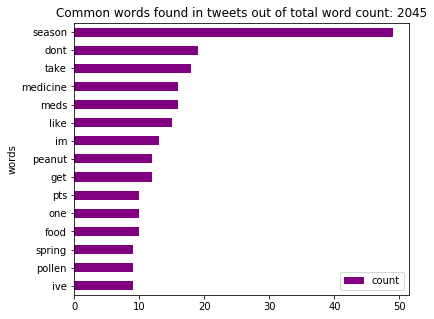

In [10]:
tweet_words = ' '.join(allergyTweets.text).split()
tweets_unsw = [[word for word in tweet_words if not word in stop_words]][0]
counts_nsw_nc= collections.Counter(tweets_unsw)
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6,5))
# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common words found in tweets out of total word count: {}".format(len(tweets_unsw)))
plt.show();

Get bigrams i.e, mostly used two word combinations in tweets and visualize network of bigrams

In [11]:
terms_bigram = list(bigrams(tweets_unsw))
bigram_counts = collections.Counter(terms_bigram)
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

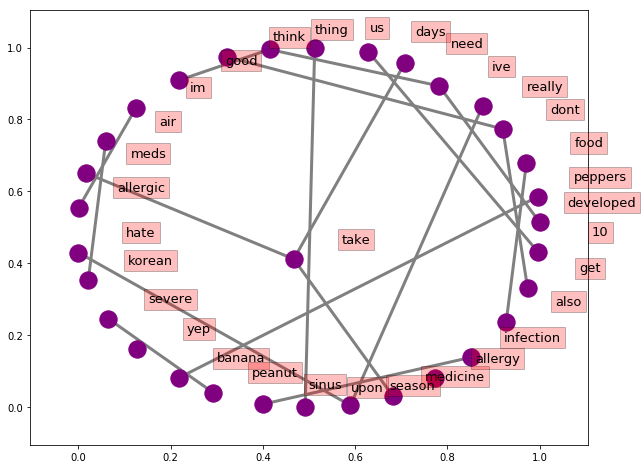

In [12]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("allergy", weight=100)
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

Plot tweeted user's location on USA geographical map with color same as sentiment as in pie chart and display tweeted text on hover.

In [13]:
def SetColor(x):
    if(x == 1):
        return colors[0]
    elif(x == 0):
        return  colors[2]
    else:
        return  colors[1]
    
data = [ go.Scattergeo(
        locationmode = 'USA-states',
        lon = allergyTweets['long'],
        lat = allergyTweets['lat'],
        text = allergyTweets['text'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            cmin = 0,
            color=list(map(SetColor, allergyTweets['sentiment']))
           
        ))]

layout = dict(
        title = 'Location of Twitter users who talked about allergy', 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = go.Figure(data=data, layout=layout )
py.iplot(fig, filename='usa-twitter-allergy' )

#### Based on negative sentiment tweets on the map, we can get location of allergy sufferers in general